In [ ]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.stats as stats
import pandas as pd
import seaborn as sns

import warnings # mute the warning spam
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

Populating the interactive namespace from numpy and matplotlib


# Direct random sampling algorithm
Suppose we want to sample a random time $\tau$ from a distribution given by a probability density function $p(t)$.

We can define the cumulative distribution in the usual way with
$$ \text{Prob}(\tau < t) = P(t) = \int_0^t p(s) ds. $$

Assume that we have $P(t)$. Consider the random variable
$$ U = P(\tau).$$
One can show that $U$ is always a uniform random variable regardless of the cumulative distribution $P$. We have
\begin{align*}
  U &\sim \text{Uniform}(0, 1) \\
  \tau &= P^{-1}(U)
\end{align*}

## Proof:
We want to show that $U$ is uniformly distributed between zero and one.
In other words, we want to show that the density function for $U$ is $f(u) = 1$.

Why do we want to show this? If we know that $U$ is uniformly distributed, we can use a programming language like Python to generate uniform random variables (this function is commonly available in many languages) and convert them to *any* type of random variable $\tau$ by inverting the cumulative distribution function, that is, we simply set
$$\tau = P^{-1}(U).$$
We don't have to develop a different algorithm to sample from every possible type of random variable. We just have to have a way of generating one kind of random variable, uniform, and it can be converted to any other kind of random variable so long as we know the distribution function. (We can even estimate the distribution function from data!)

The fact that $U \in (0, 1)$ follows from the fact that the range of *any* distribution function is $(0, 1)$. Furthermore, $P(t)$ is an increasing function with $P(0) = 0$ and $\lim_{t\to\infty}P(t) = 1$. Hence, $P(t)$ is a bijective function and the inverse function $P^{-1}(u)$ exists for all $u\in(0, 1)$ (**even if we cannot always compute the inverse function explicitly**).


For the next step, recall that the cumulative distribution function for $\tau$ is
$$P(t) = \text{Prob}[\tau < t] = \int_0^t p(t')dt'.$$
We begin by noting that since $P(t)$ is an increasing function, its inverse function $P^{-1}(u)$ is also an increasing function.
It follows that if $P(\tau) < u$ then $\tau < P^{-1}(u)$.
The cumulative distribution function for $U = P(\tau)$ is
$$
F(u) = \text{Prob}[U < u] = \text{Prob}[P(\tau) < u] = \text{Prob}[\tau < P^{-1}(u)] = P(P^{-1}(u)) = u.
$$
It follows that the density function for $U$ is $f(u) = F'(u) = 1$.

## Example: generating exponential random times
Suppose we want to sample
$$ \tau \sim \text{Exponential}(\lambda).$$
(**This lies at the heart of the so called Gillespie algorithm for sampling continuous time Markov chains.**)
Recall that the density function is $p(t) = \lambda e^{-\lambda t}$ and the cumulative distribution function is
$$ P(t) = 1 - e^{-\lambda t}. $$

We want to solve the following for $\tau$
$$ U = P(\tau) = 1 - e^{-\lambda \tau}$$
Manipulating the above equation yields
$$ e^{-\lambda \tau} = 1 - U,$$
and
$$ -\lambda \tau = \log(1 - U),$$
Finally,
$$ \tau = -\frac{1}{\lambda} \log(1 - U) $$
Note that by symmetry, if $U \sim \text{Uniform}(0, 1)$ then we also have that $1-U \sim \text{Uniform}(0, 1)$, so we could write the above as
$$ \tau = -\frac{1}{\lambda} \log(U). $$

In [ ]:
## tau ~ Exponential(lambda)
N = 1000 # number of samples to generate
lam = 0.5 # rate parameter in the exponential distribution

u = rand(N) # u ~ Uniform(0, 1)

tau = -log(1-u)/lam

# lam*tau = -log(u)
# -lam*tau = log(u)
# exp(-lam*tau) = exp(log(u))
# exp(-lam*tau) = u

print(tau.mean(), 1/lam)

2.015812805258579 2.0


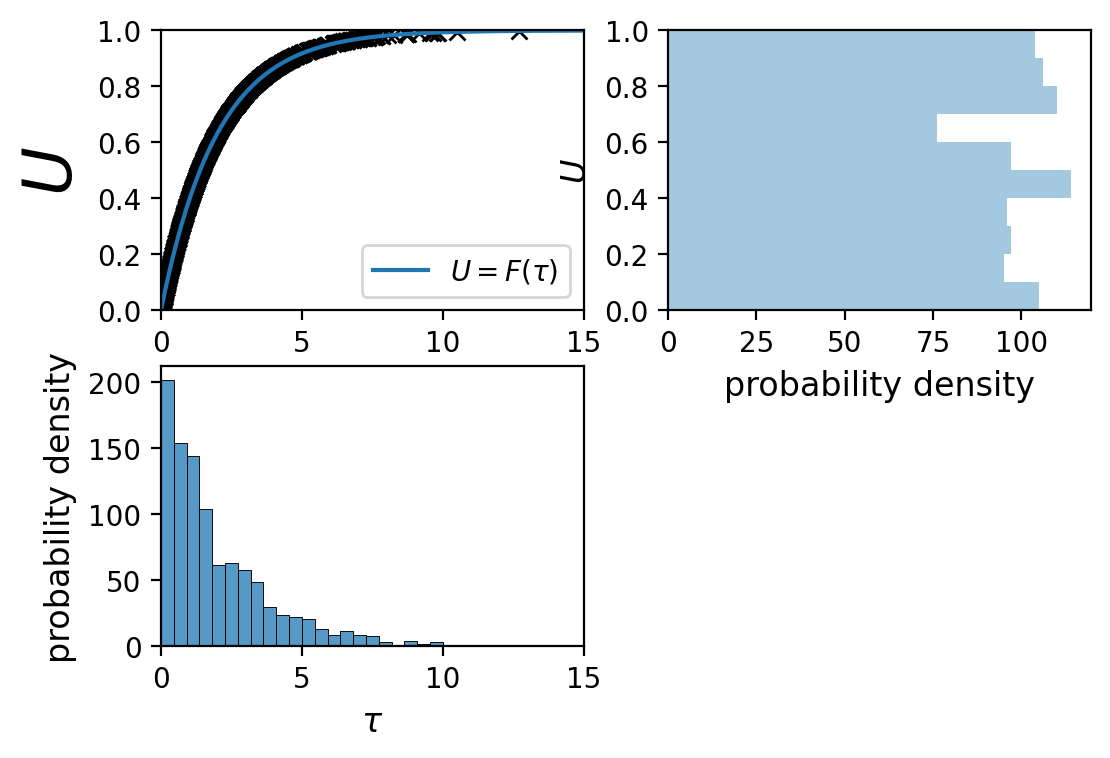

In [ ]:
fig = figure(1, [6, 4])
fig.add_subplot(221)
plot(tau, u, 'kx')

t = linspace(0, 15, 100)
P = 1 - exp(-lam*t)
plot(t, P, label=r'$U = F(\tau)$')

ylabel(r'$U$', fontsize=24)
xlabel(r'$\tau$', fontsize=24)

xlim(0, 15)
ylim(0, 1)
legend()


fig.add_subplot(222)
sns.distplot(u, vertical=True, kde=False)

ylim(0, 1)
ylabel(r'$U$', fontsize=12)
xlabel(r'probability density', fontsize=12)


fig.add_subplot(223)
sns.histplot(tau, kde=False)
xlim(0, 15)
ylabel(r'probability density', fontsize=12)
xlabel(r'$\tau$', fontsize=12);


## Sampling from categorical distributions
The above procedure also applies to discrete random variables. Let $0\leq N \leq N_{\rm max}$ be a categorical random variable and let $p(n)$ be its probability distribution. We can generate samples with
\begin{align*}
  U &\sim \text{Uniform}(0, 1) \\
  N &= \min_j\left\{U < \sum_{n=0}^j p(n) \right\}
\end{align*}


In [ ]:
def sample_categorical(log_weights, Nsamples):
    ## this function can be vectorized to sample multiple distributions
    unnormalized_weights = exp(log_weights - log_weights.max())
    W_unnormalized = cumsum(unnormalized_weights) ## we will have
    W = W_unnormalized/W_unnormalized[-1]
    u = rand(Nsamples)
    c = searchsorted(W, u)
    return c

log_weights = tau[:10]
Nsamples = 100

unnormalized_weights = exp(log_weights - log_weights.max())

W_unnormalized = cumsum(unnormalized_weights) ## we will have W_unnormalized[-1] != 1

W = W_unnormalized/W_unnormalized[-1]
u = rand(Nsamples)

c = searchsorted(W, u)



In [ ]:
unnormalized_weights[0]

0.5610238994351985

# Distributions can be approximately represented by a collection of samples
Suppose we have $N$ i.i.d samples $x_j \sim f$ from a density $f(x)$. We can approximate the density function with
$$ f(x) \approx \frac{1}{N}\sum_{j=1}^N \delta(x - x_j),$$
where $\delta()$ is the Dirac delta function.

$$ \int_{-\infty}^x \delta(u - x') du =
\begin{cases}
1, & x > x'\\
0, & \text{otherwise}
\end{cases}
$$

$$
g(y) = \int_{-\infty}^{\infty} g(x)\delta(x - y) dx
$$
Mean or expectation
$$ E[x] = \int_{-\infty}^{\infty} x f(x) dx \approx \int_{-\infty}^{\infty} x \frac{1}{N}\sum_{j=1}^N \delta(x - x_j) dx $$
$$=\frac{1}{N}\sum_{j=1}^N \int_{-\infty}^{\infty} x \delta(x - x_j) dx$$
$$=\frac{1}{N}\sum_{j=1}^N x_j$$
which is the standard empirical sample mean.

# Importance sampling
We might not be able to sample from the distribution we are interested in. We can still approximate the density function if we can sample from another distribution that is compatible.

Suppose we have $N$ i.i.d samples $x_j \sim q$ from a density $q(x)$. We can approximate the density function $f(x)$ with
$$ f(x) \approx \sum_{j=1}^N w_j\delta(x - x_j),$$
where the unnormalized importance weights are given by
$$\hat{w}_j = \frac{f(x_j)}{q(x_j)}$$
and the normalized weights are
$$ w_j = \frac{\hat{w}_j}{\sum_{i=1}^N w_i} $$

# Markov chain examples
Markov chains are defined through a stepping rule (sometimes called a propegator) that tells us how to move the chain forward one step, from $X_{t-1}$ to $X_t$.

The rule for Markov chains is that the stepping rule can only depend on the most recent previous step. That is,
$$ X_t = g(X_{t-1}).$$

For example, the chain $ X_t = g(X_{t-1}, X_{t-2})$ is not Markovian because the stepping rule depends on $X_{t-1}$ and $X_{t-2}$.

## The usual way to define a Markov chain is by picking a *transition density* $f(x_t| x_{t-1})$

## Simple random walk
$$ X_t \sim X_{t-1} + \text{Normal}(0, \sigma), \quad t = 0, 1, 2, \ldots$$
with initial condition $X_0$ given.


$$ \Delta x_t = x_t - x_{t-1}$$
$$ \Delta x_t \sim \text{Normal}(0, \sigma)$$
$$x_t = \sum_{s=1}^t \Delta x_s$$

$$ x_{\infty} = \sum_{s=1}^{\infty} \Delta x_s$$

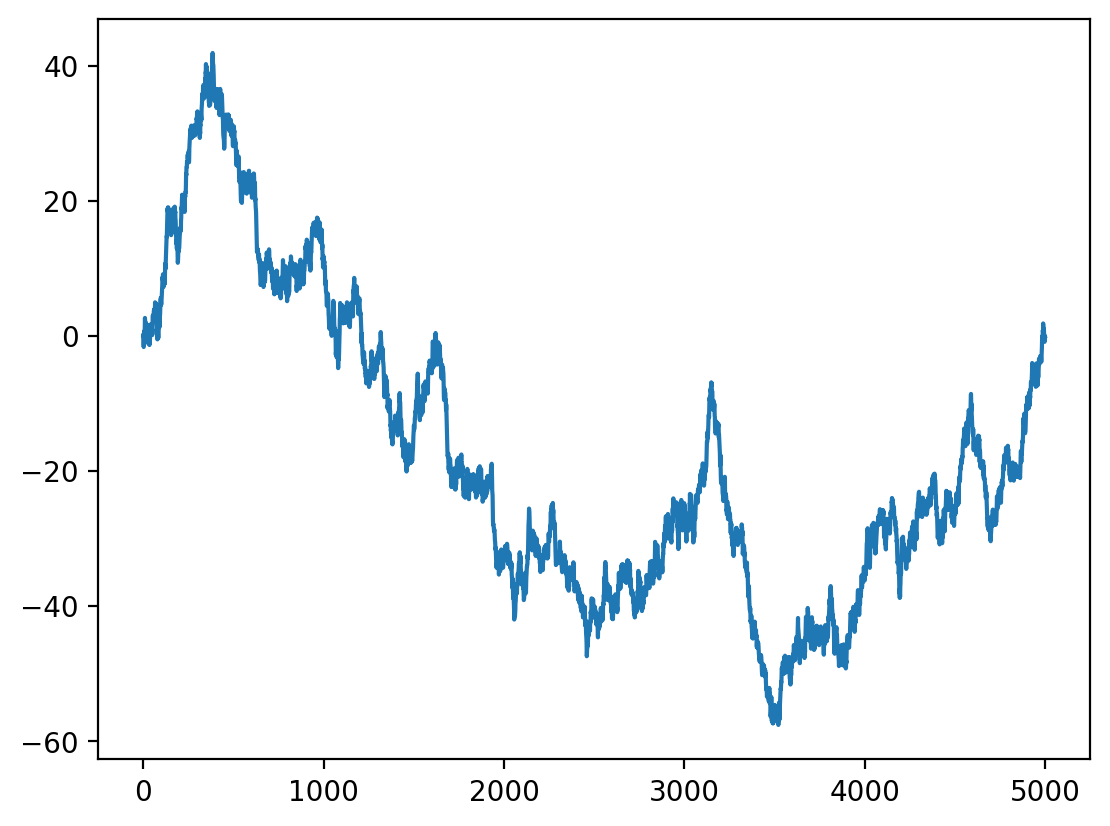

In [ ]:
Nsteps = 5000
sigma = 3./4.
x0 = 0.
x = zeros(Nsteps)
x[0] = x0
for t in arange(1, Nsteps):
    x[t] = normal(x[t-1], sigma)

plot(x);

### Probability density function for $X_t$
$$\text{Prob}[X_t \in (a, b)] \approx \int_{a}^{b}p_t(x)dx$$
The density function is $p_t(x)$ and can sometimes be written as the function $p(x, t \mid x_0)$. It satisfies a Chapman Kolmogorov equation.

### Example
Consider
$$X_t \sim \text{Normal}(0, t).$$

In [ ]:
@interact(t=(.2, 2, .1))
def pfun(t=0.2):
    figure(1, [6, 4])
    x = linspace(-5, 5, 200)
    y = sqrt(1/(2*pi))/t*exp(-x**2/(2.*t))
    plot(x, y)
    ylim(0, 2)
    show()

interactive(children=(FloatSlider(value=0.2, description='t', max=2.0, min=0.2), Output()), _dom_classes=('wid…

### We are interested in the distribution of $X_t$ in the limit $t\to \infty$
$$ \lim_{t\to\infty}p_t(x | x_0) = p_{\infty}(x)$$
**Sometime the limit does not exist.**

## Show that the (above) chain does not converge to a stationary distribution

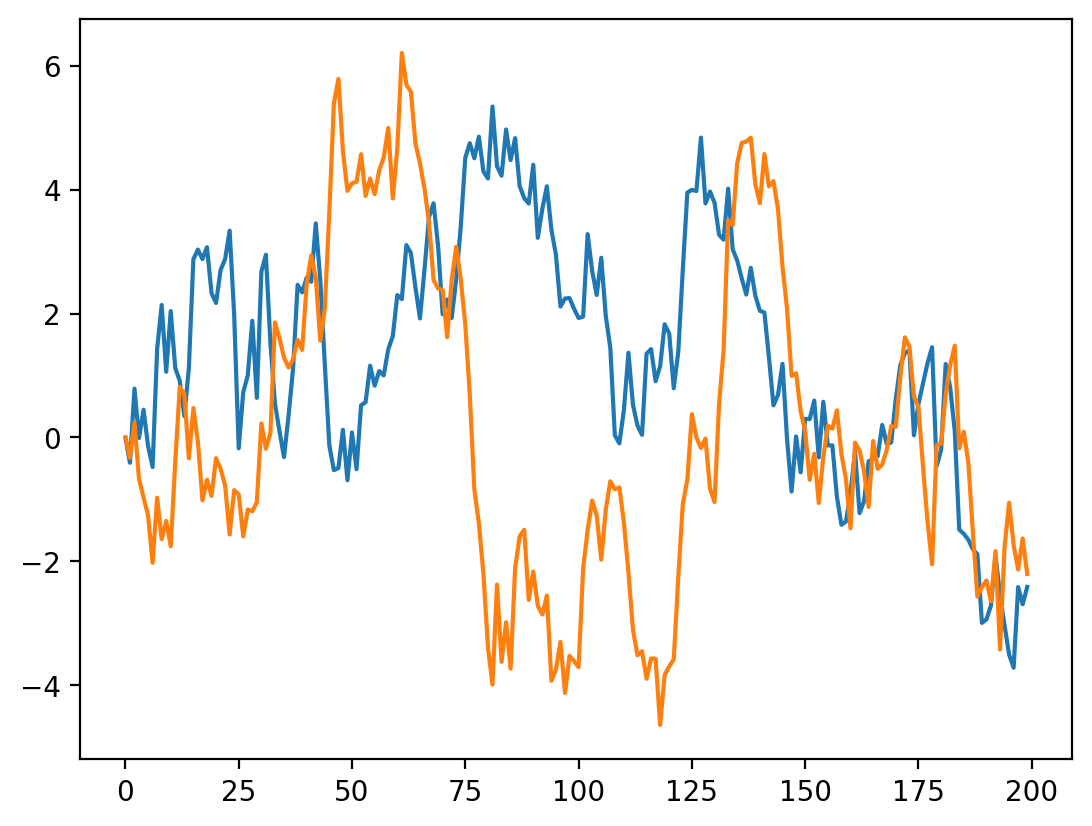

In [ ]:
Nsteps = 200
Nchains = 500
sigma = 3./4.
x0 = 0.

x = zeros([Nchains, Nsteps])
x[:, 0] = x0

for t in arange(1, Nsteps):
    x[:, t] = normal(x[:, t-1], sigma)

plot(x[0, :]); # first chain
plot(x[1, :]); # second chain

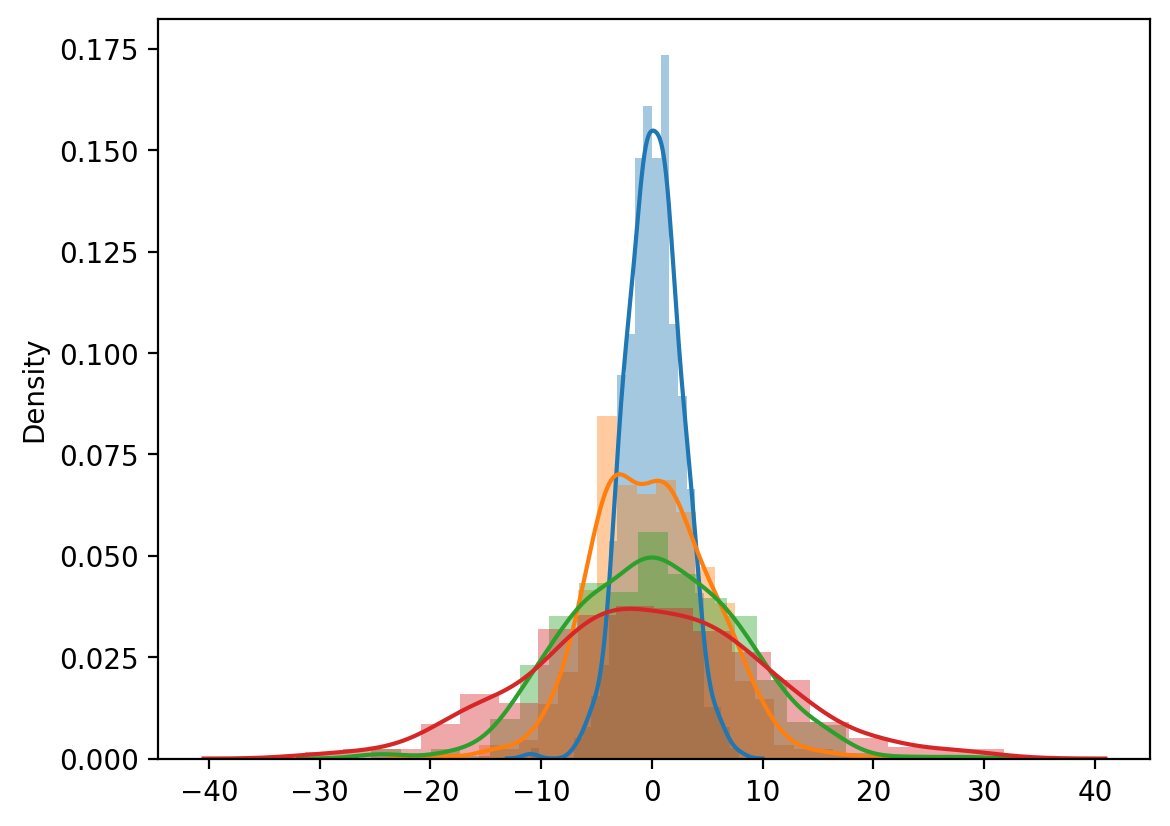

In [ ]:
sns.distplot(x[:, 10])
sns.distplot(x[:, 50])
sns.distplot(x[:, 100])
sns.distplot(x[:, -1]);

## Simple random walk + periodic boundary conditions targets a uniform distribution

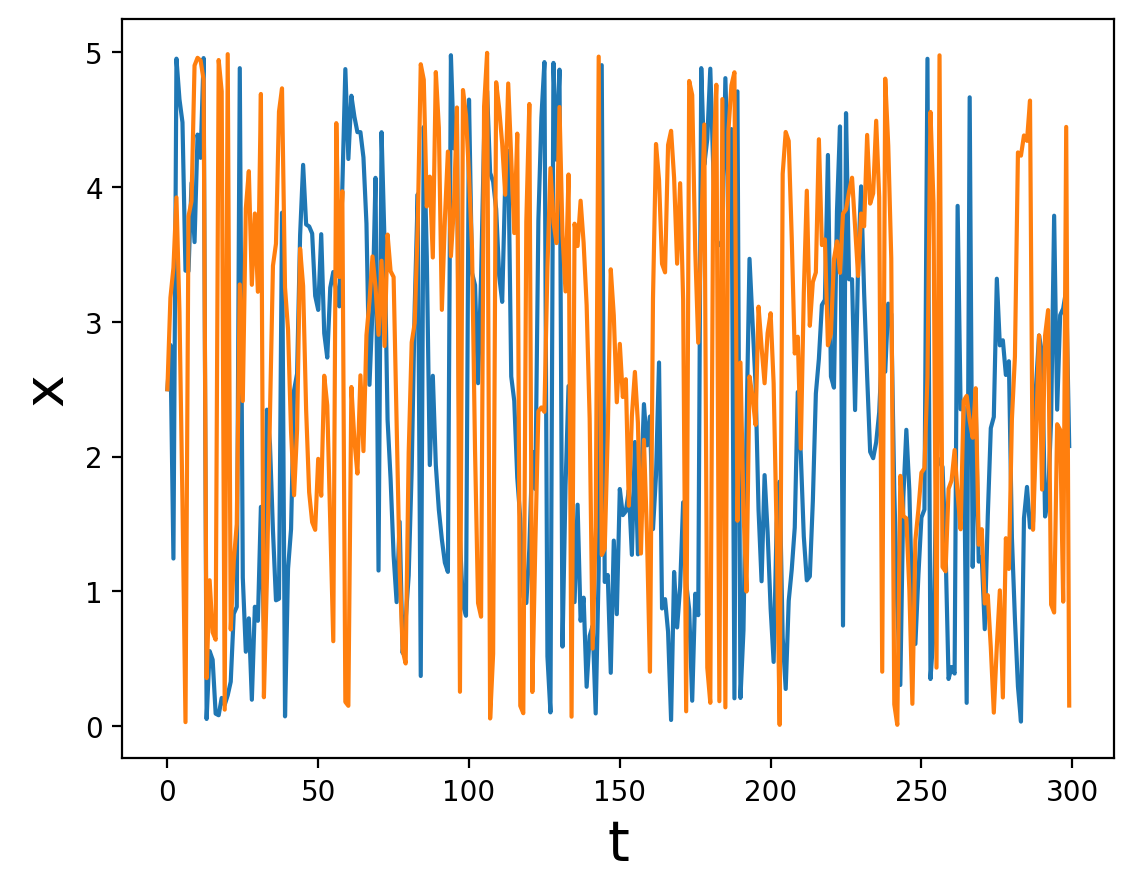

In [ ]:
Nsteps = 300
Nchains = 50000
sigma = 3./4.
x0 = 2.5

x = zeros([Nchains, Nsteps])
x[:, 0] = x0

for t in arange(1, Nsteps):
    xt = normal(x[:, t-1], sigma)
    xt[xt < 0] = 5. + xt[xt < 0]
    xt[xt > 5.] = xt[xt > 5.] - 5.
    x[:, t] = xt

plot(x[0, :]); # first chain
plot(x[1, :]); # second chain
xlabel('t', fontsize=20)
ylabel('x', fontsize=20);

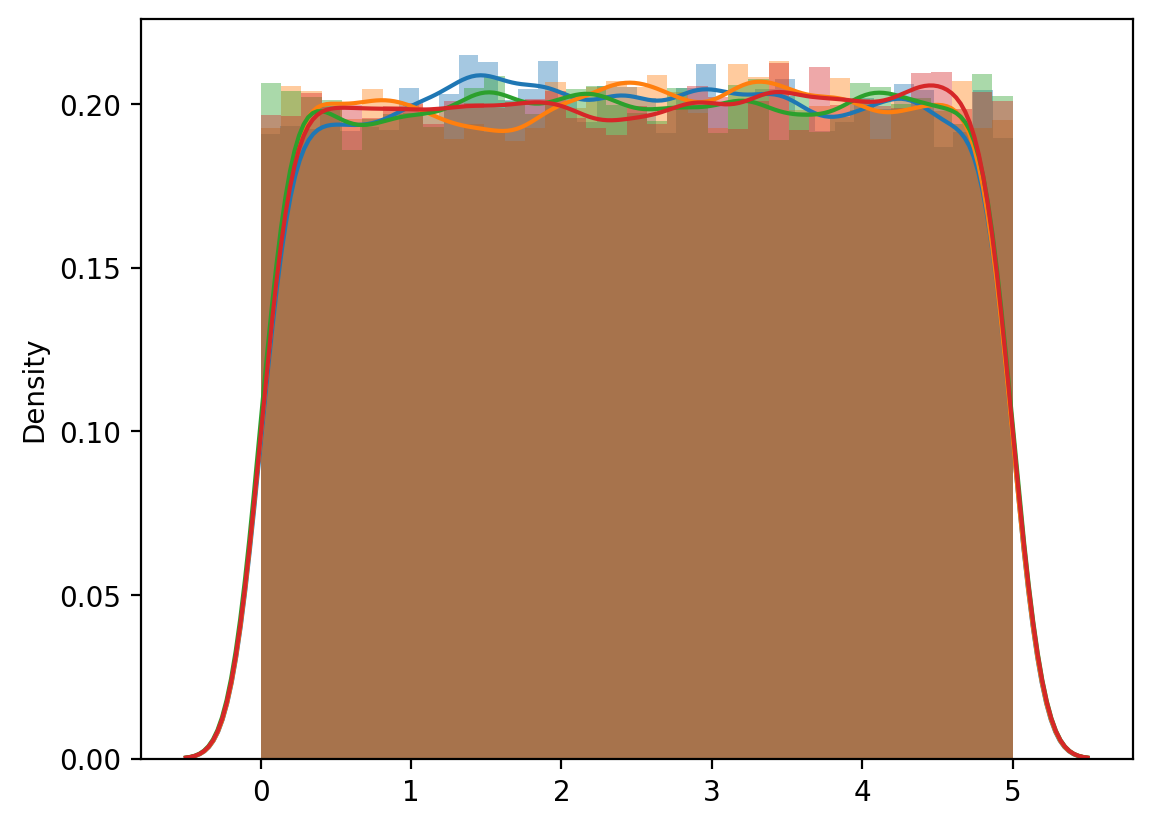

In [ ]:
sns.distplot(x[:, 10])
sns.distplot(x[:, 50])
sns.distplot(x[:, 100]);
sns.distplot(x[:, 299]);

## An Ornstein-Uhlenbeck chain targets a normal distribution
$$X_{t+1} = X_t  - pX_t + \sqrt{p}\sigma\, \text{Normal}(0, 1) $$

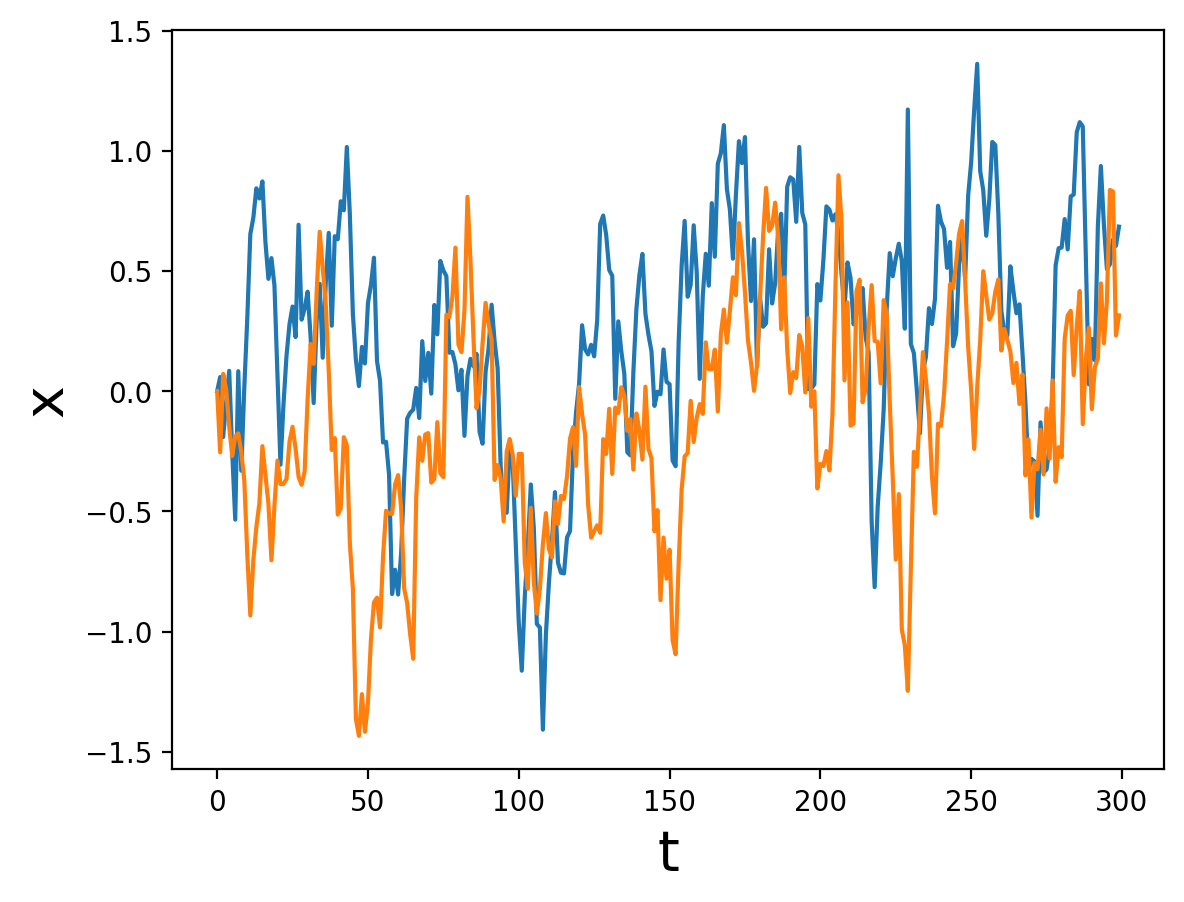

In [ ]:
Nsteps = 300
Nchains = 5000
sigma = 3./4.
p = 0.1

x0 = 0.

x = zeros([Nchains, Nsteps])
x[:, 0] = x0

for t in arange(1, Nsteps):
    x[:, t] = normal((1-p)*x[:, t-1], sqrt(p)*sigma)

plot(x[0, :]); # first chain
plot(x[1, :]); # second chain
xlabel('t', fontsize=20)
ylabel('x', fontsize=20);

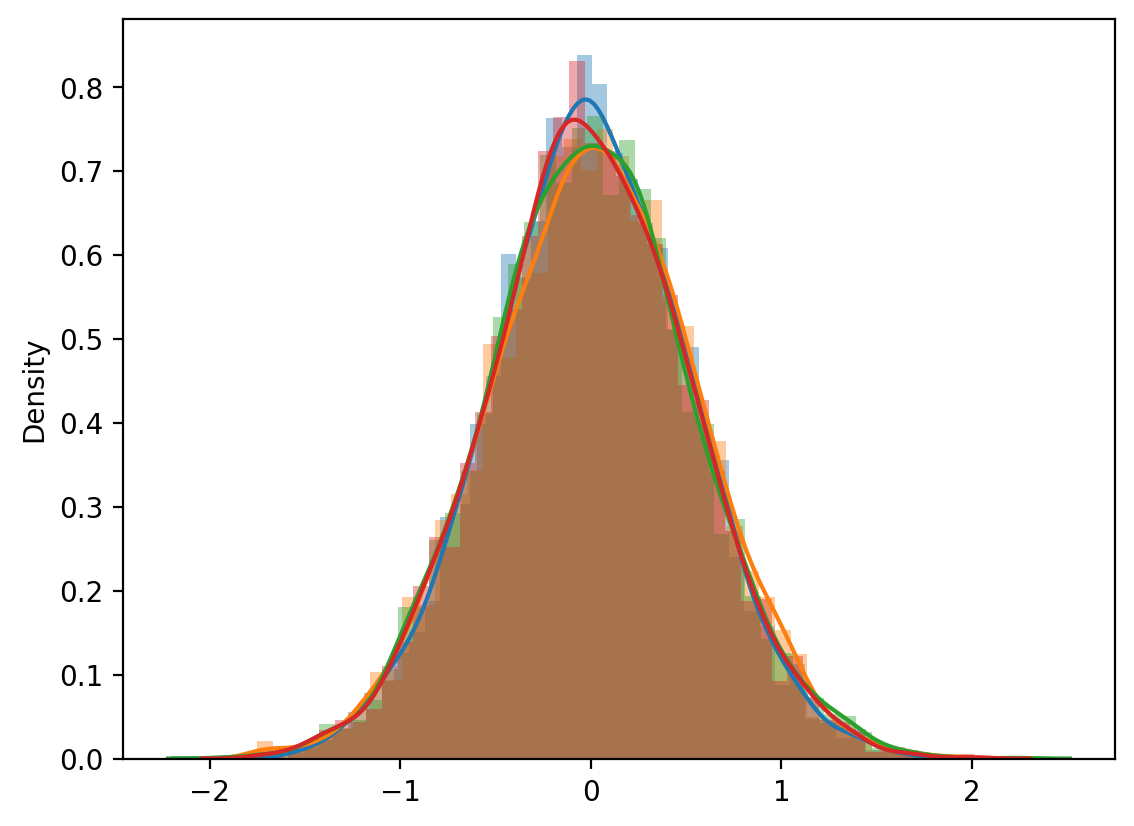

In [ ]:
sns.distplot(x[:, 10])
sns.distplot(x[:, 50])
sns.distplot(x[:, 100]);
sns.distplot(x[:, 299]);

# Metropolis - Hastings
Unfortunately, in most cases the "direct" sampling approach described above does not work. Sampling the posterior distribution is complicated by two factors.
  1. The cumulative distribution function cannot be inverted analytically
  2. We typically only have access to the *un-normalized* posterior distribution

## Problem: generate samples from an un-normalized distribution, possibly in high dimensions
We typically start with the logarithm of the so called *target* distribution. Suppose the true normalized posterior is $\Pi(\theta | D)$, where $\theta$ is one or more parameters and $D$ is the data. We will typically start with something like
$$ L(\theta | D) = \log(\alpha\Pi(\theta | D)), $$
where $\alpha$ is a constant that we do not know. Our goal is generate samples from the posterior given a function $L(\theta | D)$.

## Algorithm:
Suppose that the target density function is $u(x)$ and that we have the unnormalized log density $L(x) = \log(\alpha u(x))$.
### We want to construct a Markov chain so that the stationary density is our target distribution

### How do we know what the stationary distribution of a Markov chain will be?

## One way we can know: if the Markov chain has Detailed Balance
Construct a Markov chain $x_t$, with transition density $f(x_t | x_{t-1})$ and a stationary density $\lim_{t_0 \to -\infty} p_t(x_t | x_{t_0}) = p_{\infty}(x_t) = u(x)$ that is equal to our target density. A sufficient but not necessary condition for this is to use a Markov chain that satisfies *detailed balance*
$$f(x' | x)p_{\infty}(x) = f(x | x')p_{\infty}(x').$$
We also need for the process to be *ergodic*, which simply means that every state is sufficiently accessible for any valid initial condition.

### So we need to pick $f(x \mid x')$ so that
$$ \frac{f(x' \mid x)}{f(x \mid x')} = \frac{u(x')}{u(x)} $$

### Constructing the chain
We split the chain into two steps:
  1. a proposal step with distribution $q(x_t | x_{t-1})$
  2. an acceptance step with acceptance probability
  $$p_{MH}(x_t, x_{t-1}) = \min\left\{1, \frac{u(x_{t})q(x_{t-1} | x_{t})}{u(x_{t-1})q(x_{t} | x_{t-1})} \right\}$$
We then set our transition probability to
$$ f(x_t | x_{t-1}) =  q(x_t | x_{t-1})p_{MH}(x_t, x_{t-1}) + \delta(x_t - x_{t-1})
\int_{-\infty}^{\infty}q(x' | x_{t-1})(1 - p_{MH}(x', x_{t-1}))dx'
.$$


### Proof:
Let $A$ be the event of accepting a step and $A'$ its complement. Let $q(x_t \mid x_{t-1})$ be a user-specified proposal density. We have the conditional densities
$$g(x_t \mid x_{t-1}, A) = q(x_t \mid x_{t-1})$$
and
$$g(x_t \mid x_{t-1}, A') = \delta(x_{t} - x_{t-1})$$
Now suppose that the acceptance probability $P(A)$ is independent of $x_t$ (it is not, but let us assume it is for a moment).
Note that $P(A') = 1 - P(A)$
The step density for MH is given by using the law of total probability
$$ f(x_t \mid x_{t-1}) = g(x_t \mid x_{t-1}, A)P(A) + g(x_t \mid x_{t-1}, A')P(A') $$
$$ = q(x_t \mid x_{t-1})P(A) +\delta(x_{t} - x_{t-1})(1 - P(A)).$$

Now what happens when the acceptance probability depends on the proposed step, call it $y$?
We have
$$y \sim q(\cdot \mid x_{t-1})$$
We have the join probability (density) given by
$$ P(A', y \mid x_{t-1}) = P(A' \mid y) q(y \mid x_{t-1}).$$
Integrating over the proposal step yields
$$P(A' \mid x_{t-1}) =  \int_{-\infty}^{\infty} P(A', y \mid x_{t-1}) dy= \int_{-\infty}^{\infty} P(A' \mid y) q(y \mid x_{t-1}) dy $$
Hence,
$$ f(x_t \mid x_{t-1}) =  q(x_t \mid x_{t-1})P(A \mid x_t) +\delta(x_{t} - x_{t-1})\int_{-\infty}^{\infty}(1 - P(A \mid y)) q(y \mid x_{t-1}) dy. $$

### Proof of detailed balance:
Detailed balance (see above) requires
$$\frac{f(x' | x)}{f(x | x')} = \frac{p_{\infty}(x')}{p_{\infty}(x)} = \frac{u(x')}{u(x)}.$$

### Algorithm steps:
Given $x_0$. At step $t$:
  1. sample $\hat{x} \sim q(\cdot | x_{t-1})$
  2. calculate acceptance probability
  $$p_{MH} = \min\left\{1, \frac{u(\hat{x})q(x_{t-1} \mid \hat{x})}{u(x_{t-1})q(\hat{x} \mid x_{t-1})} \right\}$$
  3. compute $U \sim \text{Uniform}(0, 1)$
  4. compute
  $$\chi = \begin{cases}
  1, & U < p_{MH} \\
  0, & \text{otherwise}
  \end{cases}
  $$
  5. Set $x_{t} = \hat{x}\chi + x_{t-1}(1 - \chi)$

<ipython-input-15-7c7d934fe8d0>:18: RuntimeWarning: divide by zero encountered in scalar divide
  _p_MH = (target_density(xhat)
<ipython-input-15-7c7d934fe8d0>:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[t] = chi*xhat + (1-chi)*x[t-1]


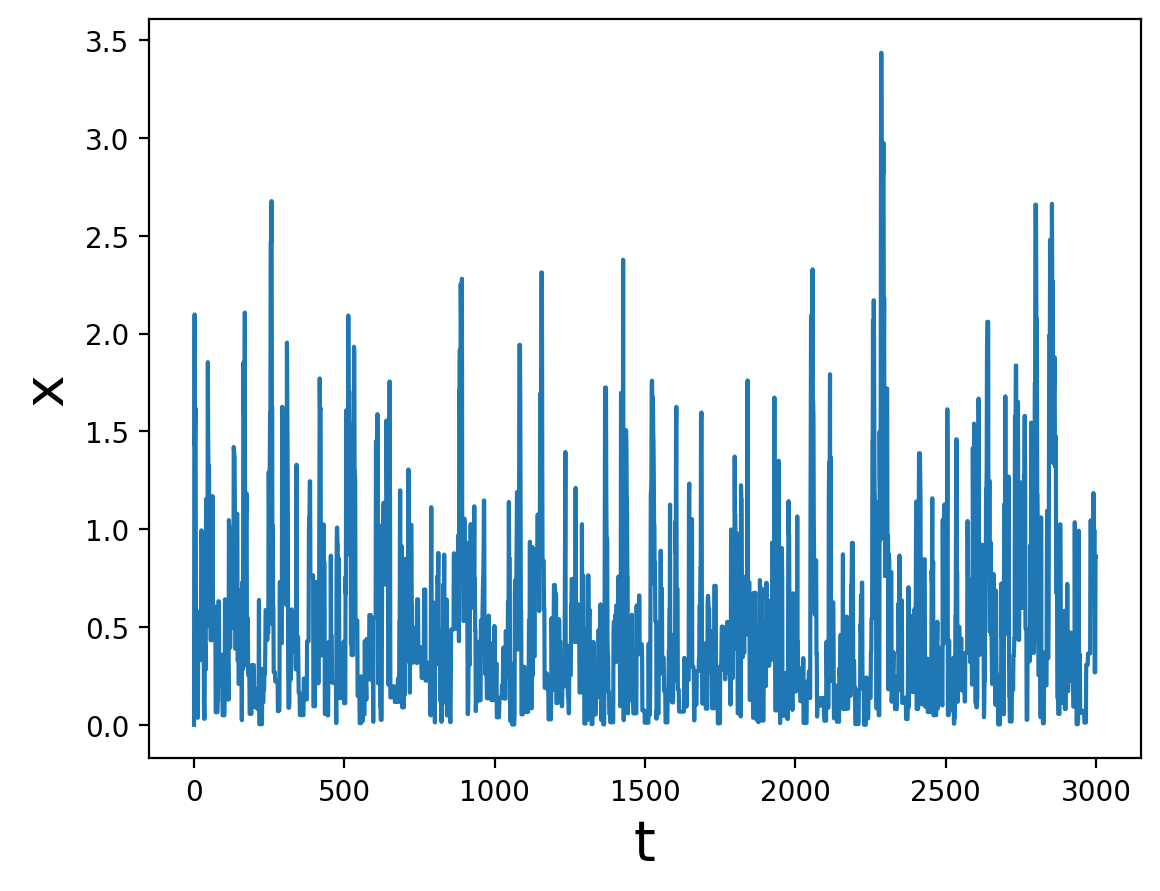

In [ ]:
import scipy.stats as stats

def target_density(x, lam=2.):
    return (x > 0)*exp(-lam*x)

def proposal_density(x, y, sigma=1.):
    return stats.norm.pdf(x, y, sigma)

Nsteps = 3000

x0 = 0.

x = zeros([Nsteps])
x[0] = x0

for t in arange(1, Nsteps):
    xhat = normal(x[t-1], sigma)
    _p_MH = (target_density(xhat)
        *proposal_density(x[t-1], xhat)
        /target_density(x[t-1])
        /proposal_density(xhat, x[t-1]))
    p_MH = minimum(1, _p_MH)
    U = rand(1)
    chi = (U < p_MH)
    x[t] = chi*xhat + (1-chi)*x[t-1]

plot(x);
xlabel('t', fontsize=20)
ylabel('x', fontsize=20);

<Axes: ylabel='Density'>

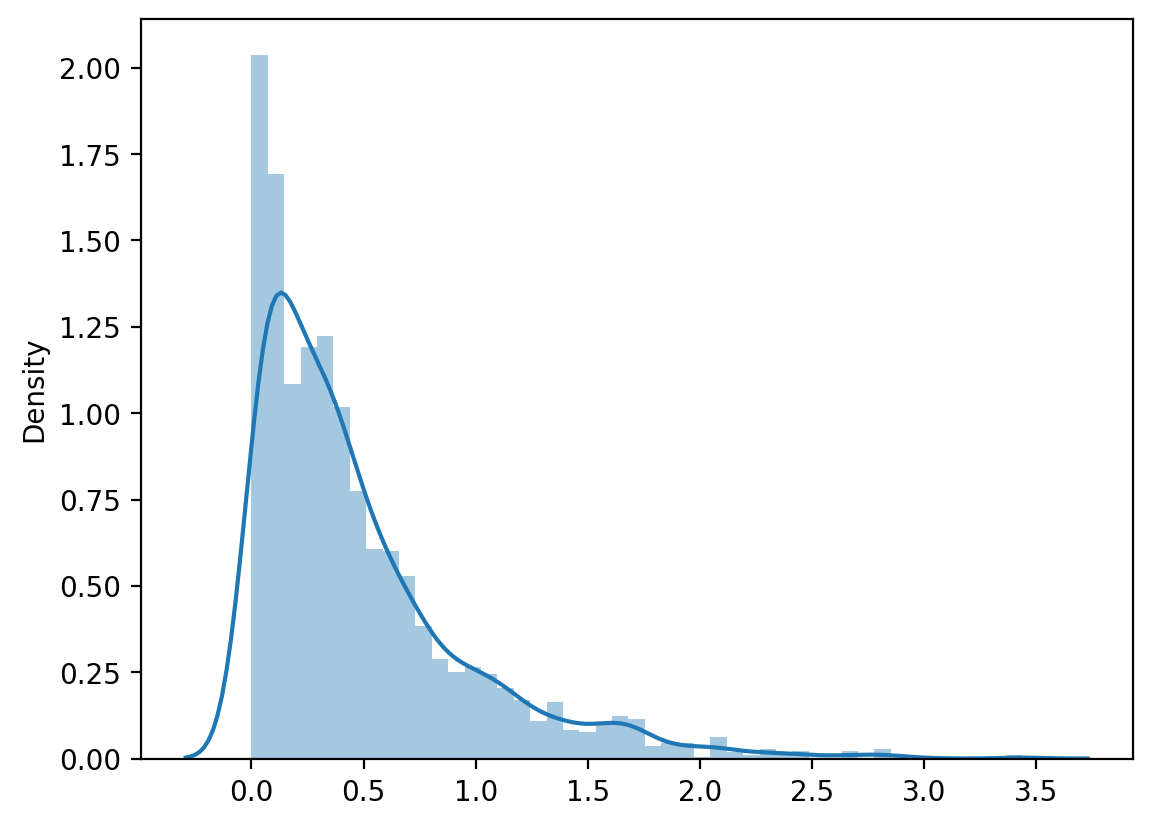

In [ ]:
sns.distplot(x)

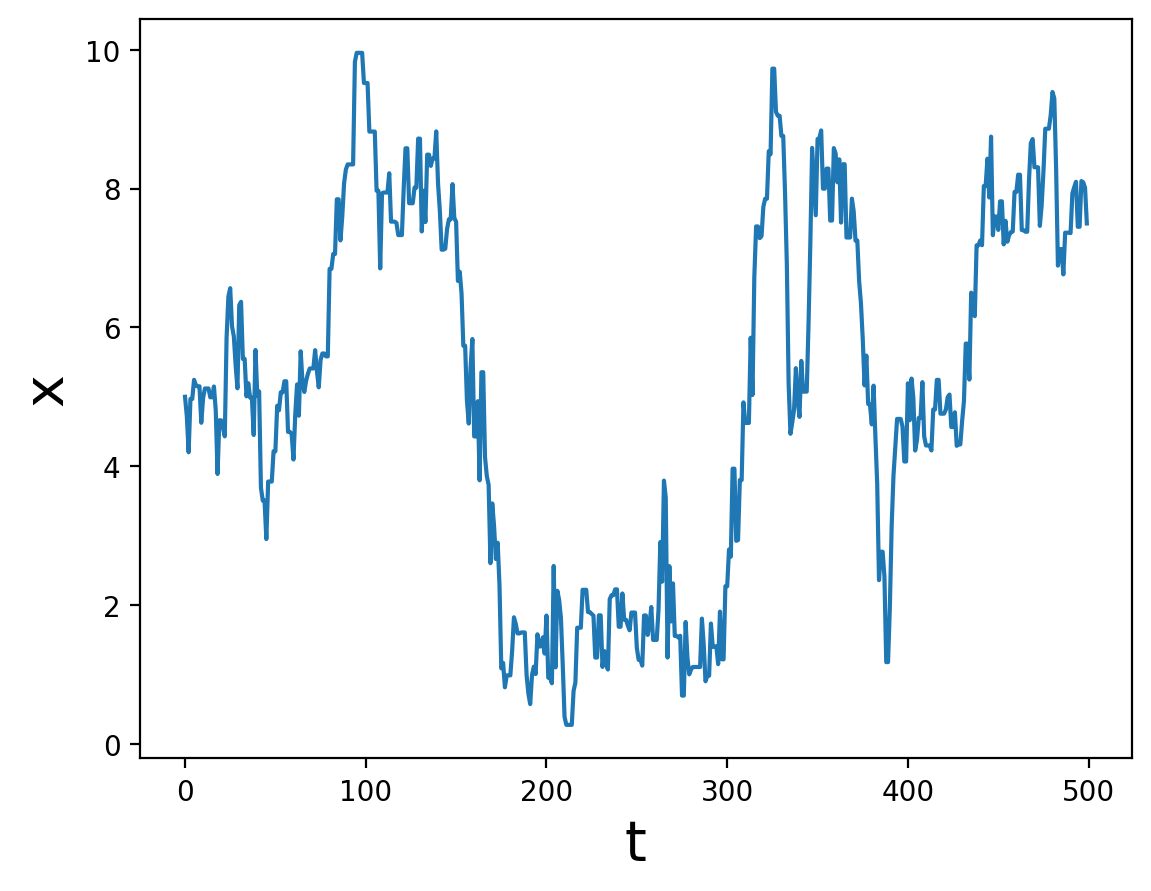

In [ ]:
import scipy.stats as stats

# def target_density(x, lam=2.):
#     return (x > 0)*exp(-lam*x)

# def target_density(x, x1=-2., x2=2.):
#     return exp(-(x - x1)**2/2.) + exp(-(x - x2)**2/2.)

def target_density(x):
    return (x>0)*(x<10)*(0.1 + sin(x)**2)

def proposal_density(x, y, sigma=1.):
    return stats.norm.pdf(x, y, sigma)

Nsteps = 500
Nchains = 1000
x0 = 5.

x = zeros([Nchains, Nsteps])
x[:, 0] = x0

for t in arange(1, Nsteps):
    xhat = normal(x[:, t-1], sigma)
    _p_MH = (target_density(xhat)
        *proposal_density(x[:, t-1], xhat)
        /target_density(x[:, t-1])
        /proposal_density(xhat, x[:, t-1]))
    p_MH = minimum(1, _p_MH)
    U = rand(Nchains)
    chi = (U < p_MH)
    x[:, t] = chi*xhat + (1-chi)*x[:, t-1]

plot(x[0, :]);
xlabel('t', fontsize=20)
ylabel('x', fontsize=20);

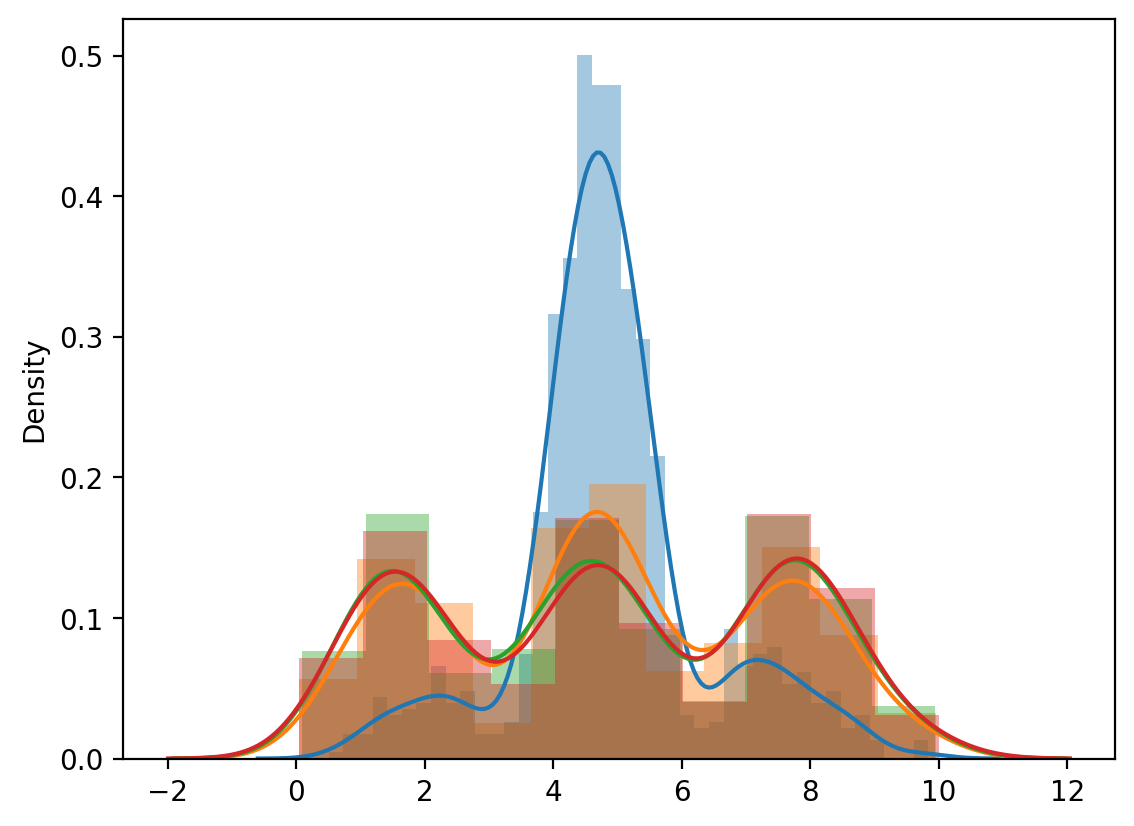

In [ ]:
sns.distplot(x[:, 10])
sns.distplot(x[:, 50])
sns.distplot(x[:, 100]);
sns.distplot(x[:, 299]);

## Disadvantages

  1. $x_{t+s}$ and $x_t$ are correlated for small $s$. We cannot treat all the steps of the chain as independent samples of the target distribution
  2. The samples converge to samples of the target distribution as the number of steps $t\to\infty$. In practice we need $t$ large enough, and sometimes, this can be too large for practical purposes.
  3. The choice of initial condition $x_0$ leads to transient behavior in the chain, and it is often necessary to run a "burn in" chain for some number of steps to produce a better initial condition.

# Gibbs sampling
Suppose we want to sample from a high dimensional joint distribution
$$ p(x_1, x_2, \ldots, x_n)$$
The strategy is to construct a Markov chain by sampling each coordinate sequentially. That is, for $j=1,2,\ldots, n$ we set the jth component of ${\bf x}^t$ to
$$ x_j^t \sim p(\cdot | x_1^t, x_2^t, \ldots, x_{j-1}^t, x_{j+1}^{t-1}, \ldots, x_n^{t-1}) \propto p(x_1^t, x_2^t, \ldots, x_{j-1}^t, \cdot , x_{j+1}^{t-1}, \ldots, x_n^{t-1})$$
One can show that this generates a Markov chain with the desired target distribution.